In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    recall_score,
)


In [2]:
df = pd.read_csv('shipping.csv', index_col='ID')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10999 entries, 1 to 10999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.0+ MB


In [4]:
df.columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

In [5]:
df.sample(10)

Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
ID                                                                             
10736               F             Ship                    4                4   
2705                C             Ship                    3                3   
3218                F             Ship                    4                1   
1506                F           Flight                    4                2   
9816                F             Ship                    4                3   
6872                F             Ship                    5                2   
4117                D           Flight                    3                4   
332                 F             Ship                    4                3   
10563               A           Flight                    3                5   
2248                B             Ship                    3                2   

       Cost_of_the_Product  Prior_purchases Product_importance Gender  \
ID                                                                      
10736                  229                6             medium      F   
2705                   257                3                low      M   
3218                   164                4                low      M   
1506                   229                4                low      F   
9816                   125                3                low      F   
6872                   266                5                low      F   
4117                   259                4             medium      F   
332                    140                3               high      F   
10563                  190                5               high      F   
2248                   206                2                low      M   

       Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
ID                                                           
10736                 8           1175                    0  
2705                 64           3103                    1  
3218                  6           4432                    1  
1506                 32           3518                    1  
9816                 10           5883                    0  
6872                 10           1274                    1  
4117                  5           4564                    1  
332                  46           1072                    1  
10563                 7           4457                    0  
2248                  3           2261                    1

In [6]:
df['Reached.on.Time_Y.N'].value_counts()

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

In [7]:
duplicated_rows_count = df.duplicated().sum()
print('Duplicated rows (row by row):', duplicated_rows_count)

Duplicated rows (row by row): 0


In [8]:
df[["Customer_care_calls", "Customer_rating", "Cost_of_the_Product", "Prior_purchases", "Discount_offered", "Weight_in_gms"]].describe()

Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count         10999.000000     10999.000000         10999.000000   
mean              4.054459         2.990545           210.196836   
std               1.141490         1.413603            48.063272   
min               2.000000         1.000000            96.000000   
25%               3.000000         2.000000           169.000000   
50%               4.000000         3.000000           214.000000   
75%               5.000000         4.000000           251.000000   
max               7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  
count     10999.000000      10999.000000   10999.000000  
mean          3.567597         13.373216    3634.016729  
std           1.522860         16.205527    1635.377251  
min           2.000000          1.000000    1001.000000  
25%           3.000000          4.000000    1839.500000  
50%           3.000000          7.000000    4149.000000  
75%           4.000000         10.000000    5050.000000  
max          10.000000         65.000000    7846.000000

In [9]:
df['Reached.on.Time_Y.N'] = df['Reached.on.Time_Y.N'].replace({0: "No", 1: "Yes"})

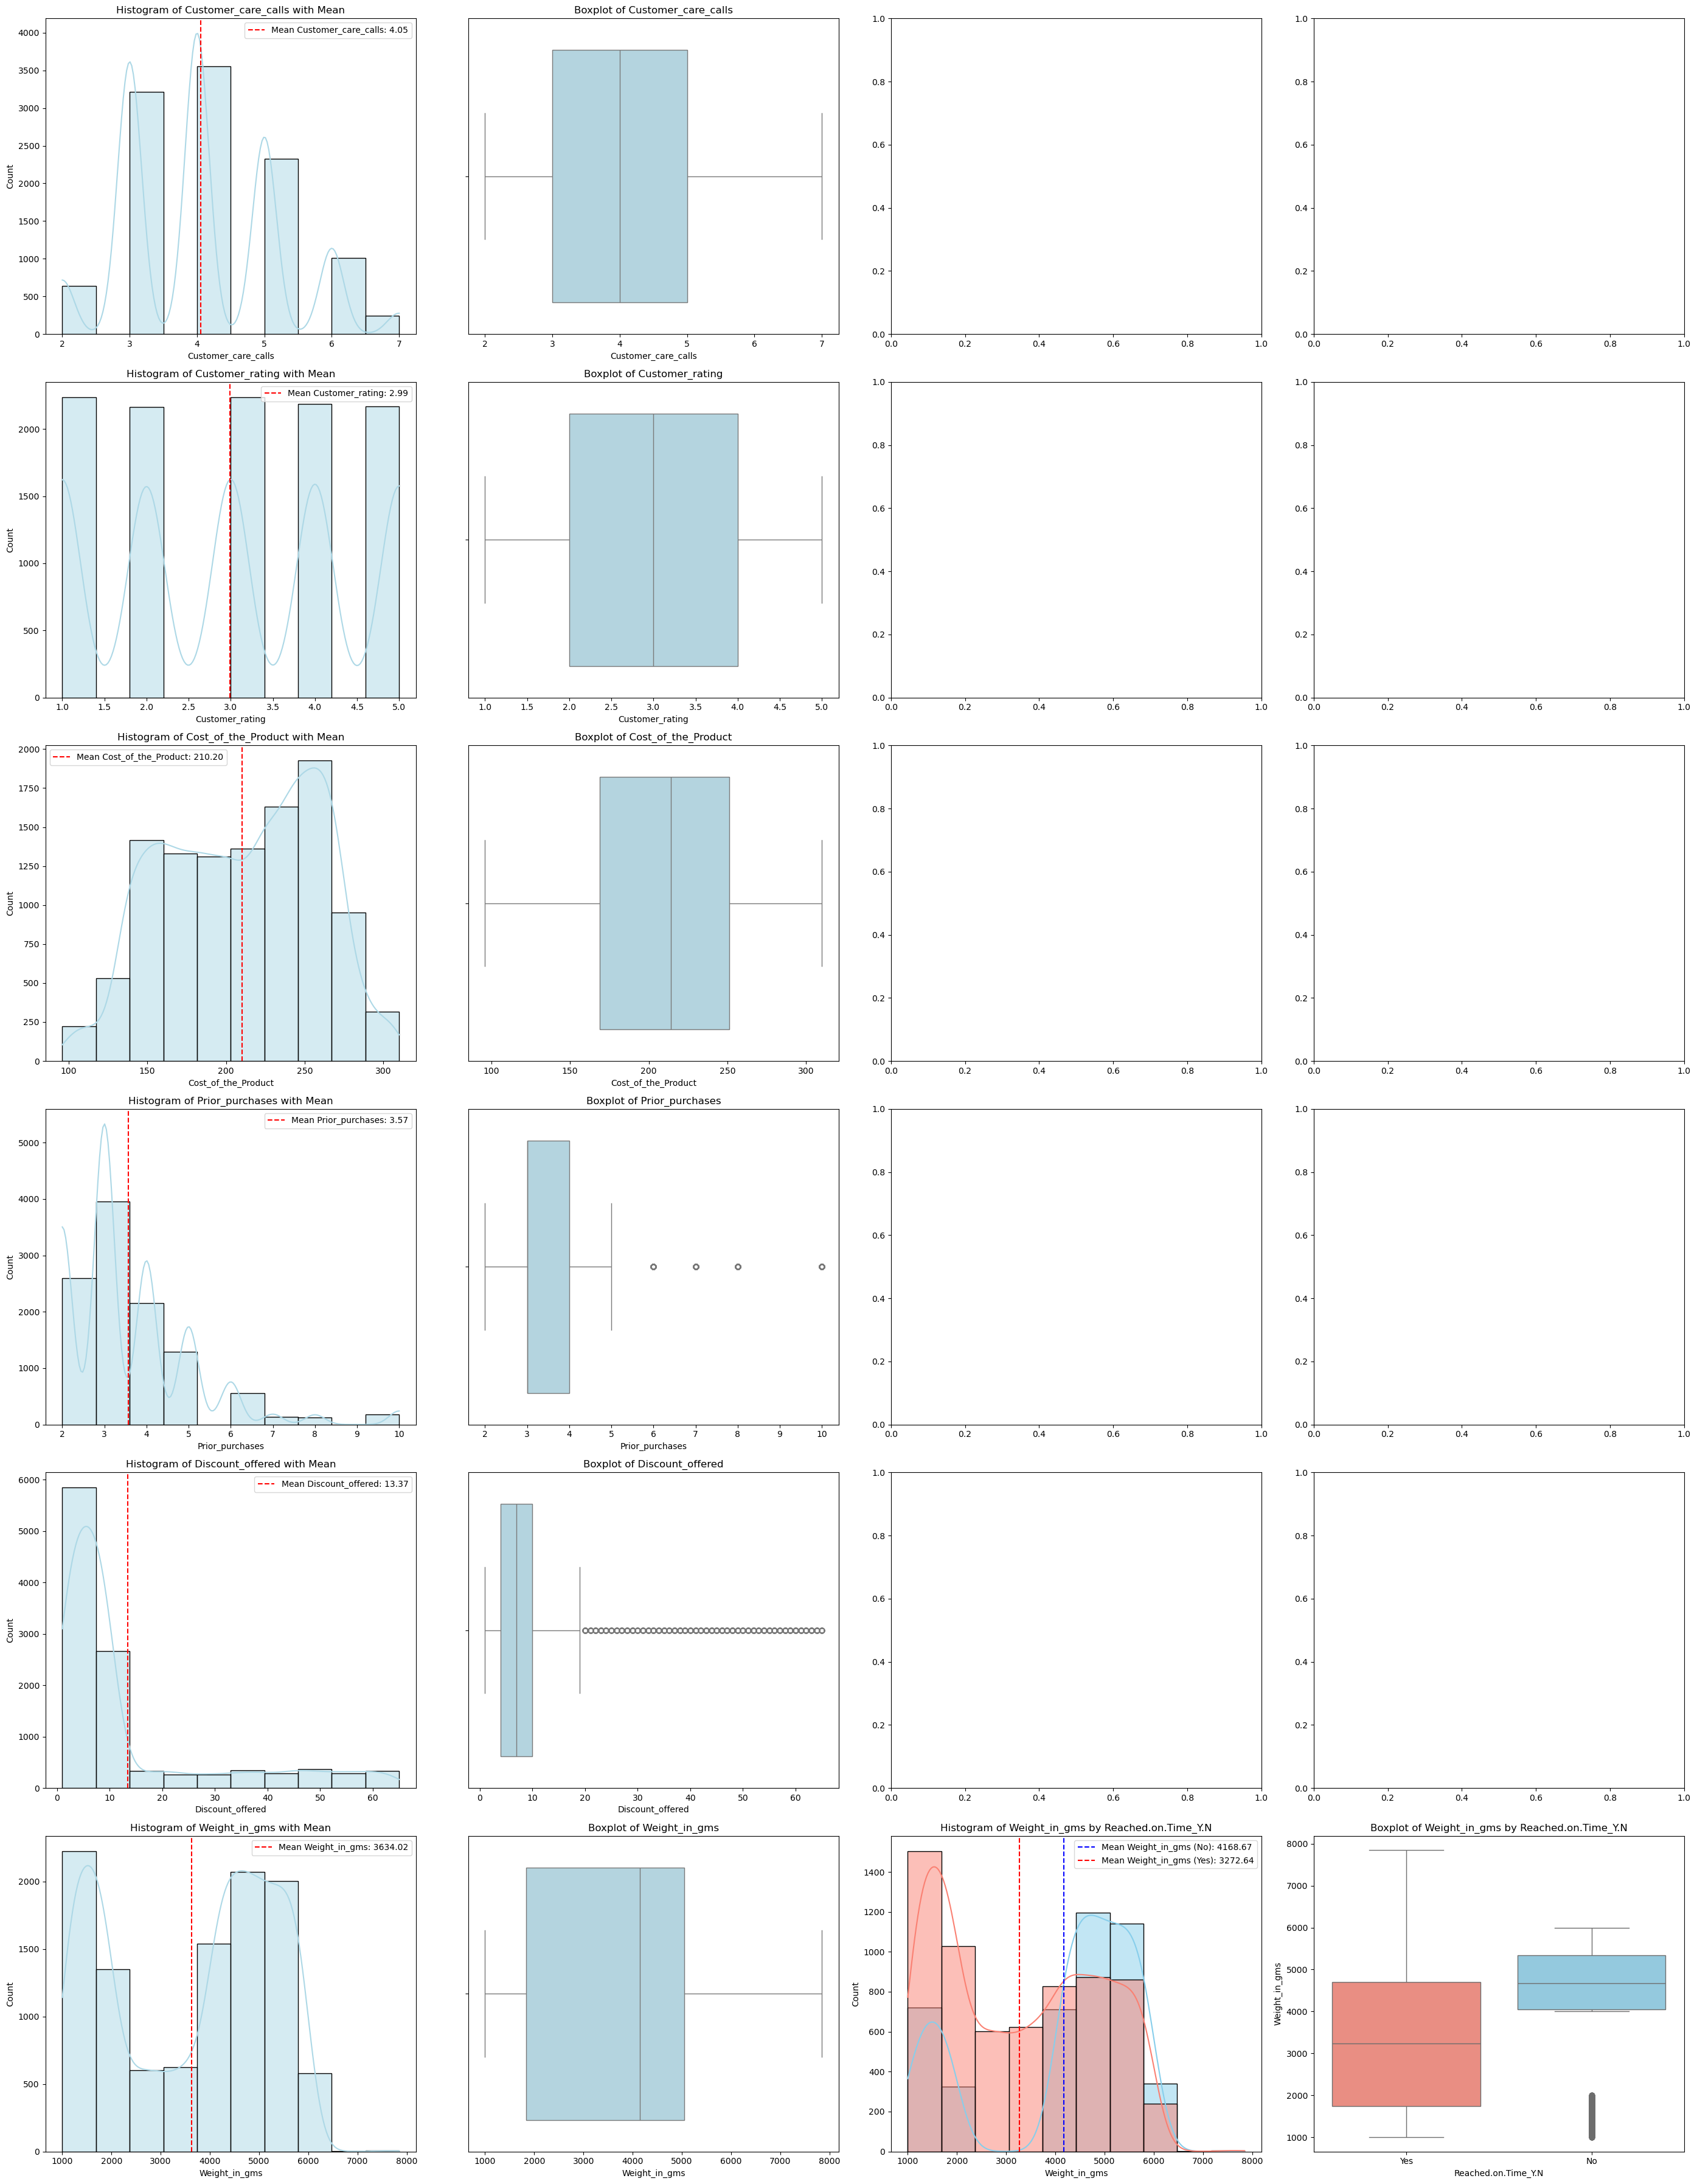

In [10]:
custom_palette = {"Yes": "salmon", "No": "skyblue"}

num_cols = [
    "Customer_care_calls", "Customer_rating",
    "Cost_of_the_Product", "Prior_purchases",
    "Discount_offered", "Weight_in_gms"
]
cat_col = "Reached.on.Time_Y.N"

fig, axes = plt.subplots(len(num_cols), 4, figsize=(28, 36))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0], bins=10, color="lightblue")
    axes[i, 0].axvline(
        df[col].mean(),
        color="red",
        linestyle="--",
        label=f"Mean {col}: {df[col].mean():.2f}",
    )
    axes[i, 0].legend()
    axes[i, 0].set_title(f"Histogram of {col} with Mean")

    sns.boxplot(x=df[col], ax=axes[i, 1], color="lightblue")
    axes[i, 1].set_title(f"Boxplot of {col}")

sns.histplot(
        data=df,
        x=col,
        hue=cat_col,
        kde=True,
        ax=axes[i, 2],
        bins=10,
        palette=custom_palette,
    )
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
        if grp in df[cat_col].unique():
            axes[i, 2].axvline(
                df[df[cat_col] == grp][col].mean(),
                color=color,
                linestyle="--",
                label=f"Mean {col} ({grp}): {df[df[cat_col] == grp][col].mean():.2f}",
            )
axes[i, 2].legend()
axes[i, 2].set_title(f"Histogram of {col} by {cat_col}")

sns.boxplot(x=cat_col, y=col, hue=cat_col, data=df, ax=axes[i, 3], palette=custom_palette, legend=False)
axes[i, 3].set_title(f"Boxplot of {col} by {cat_col}")

plt.tight_layout()
plt.show()

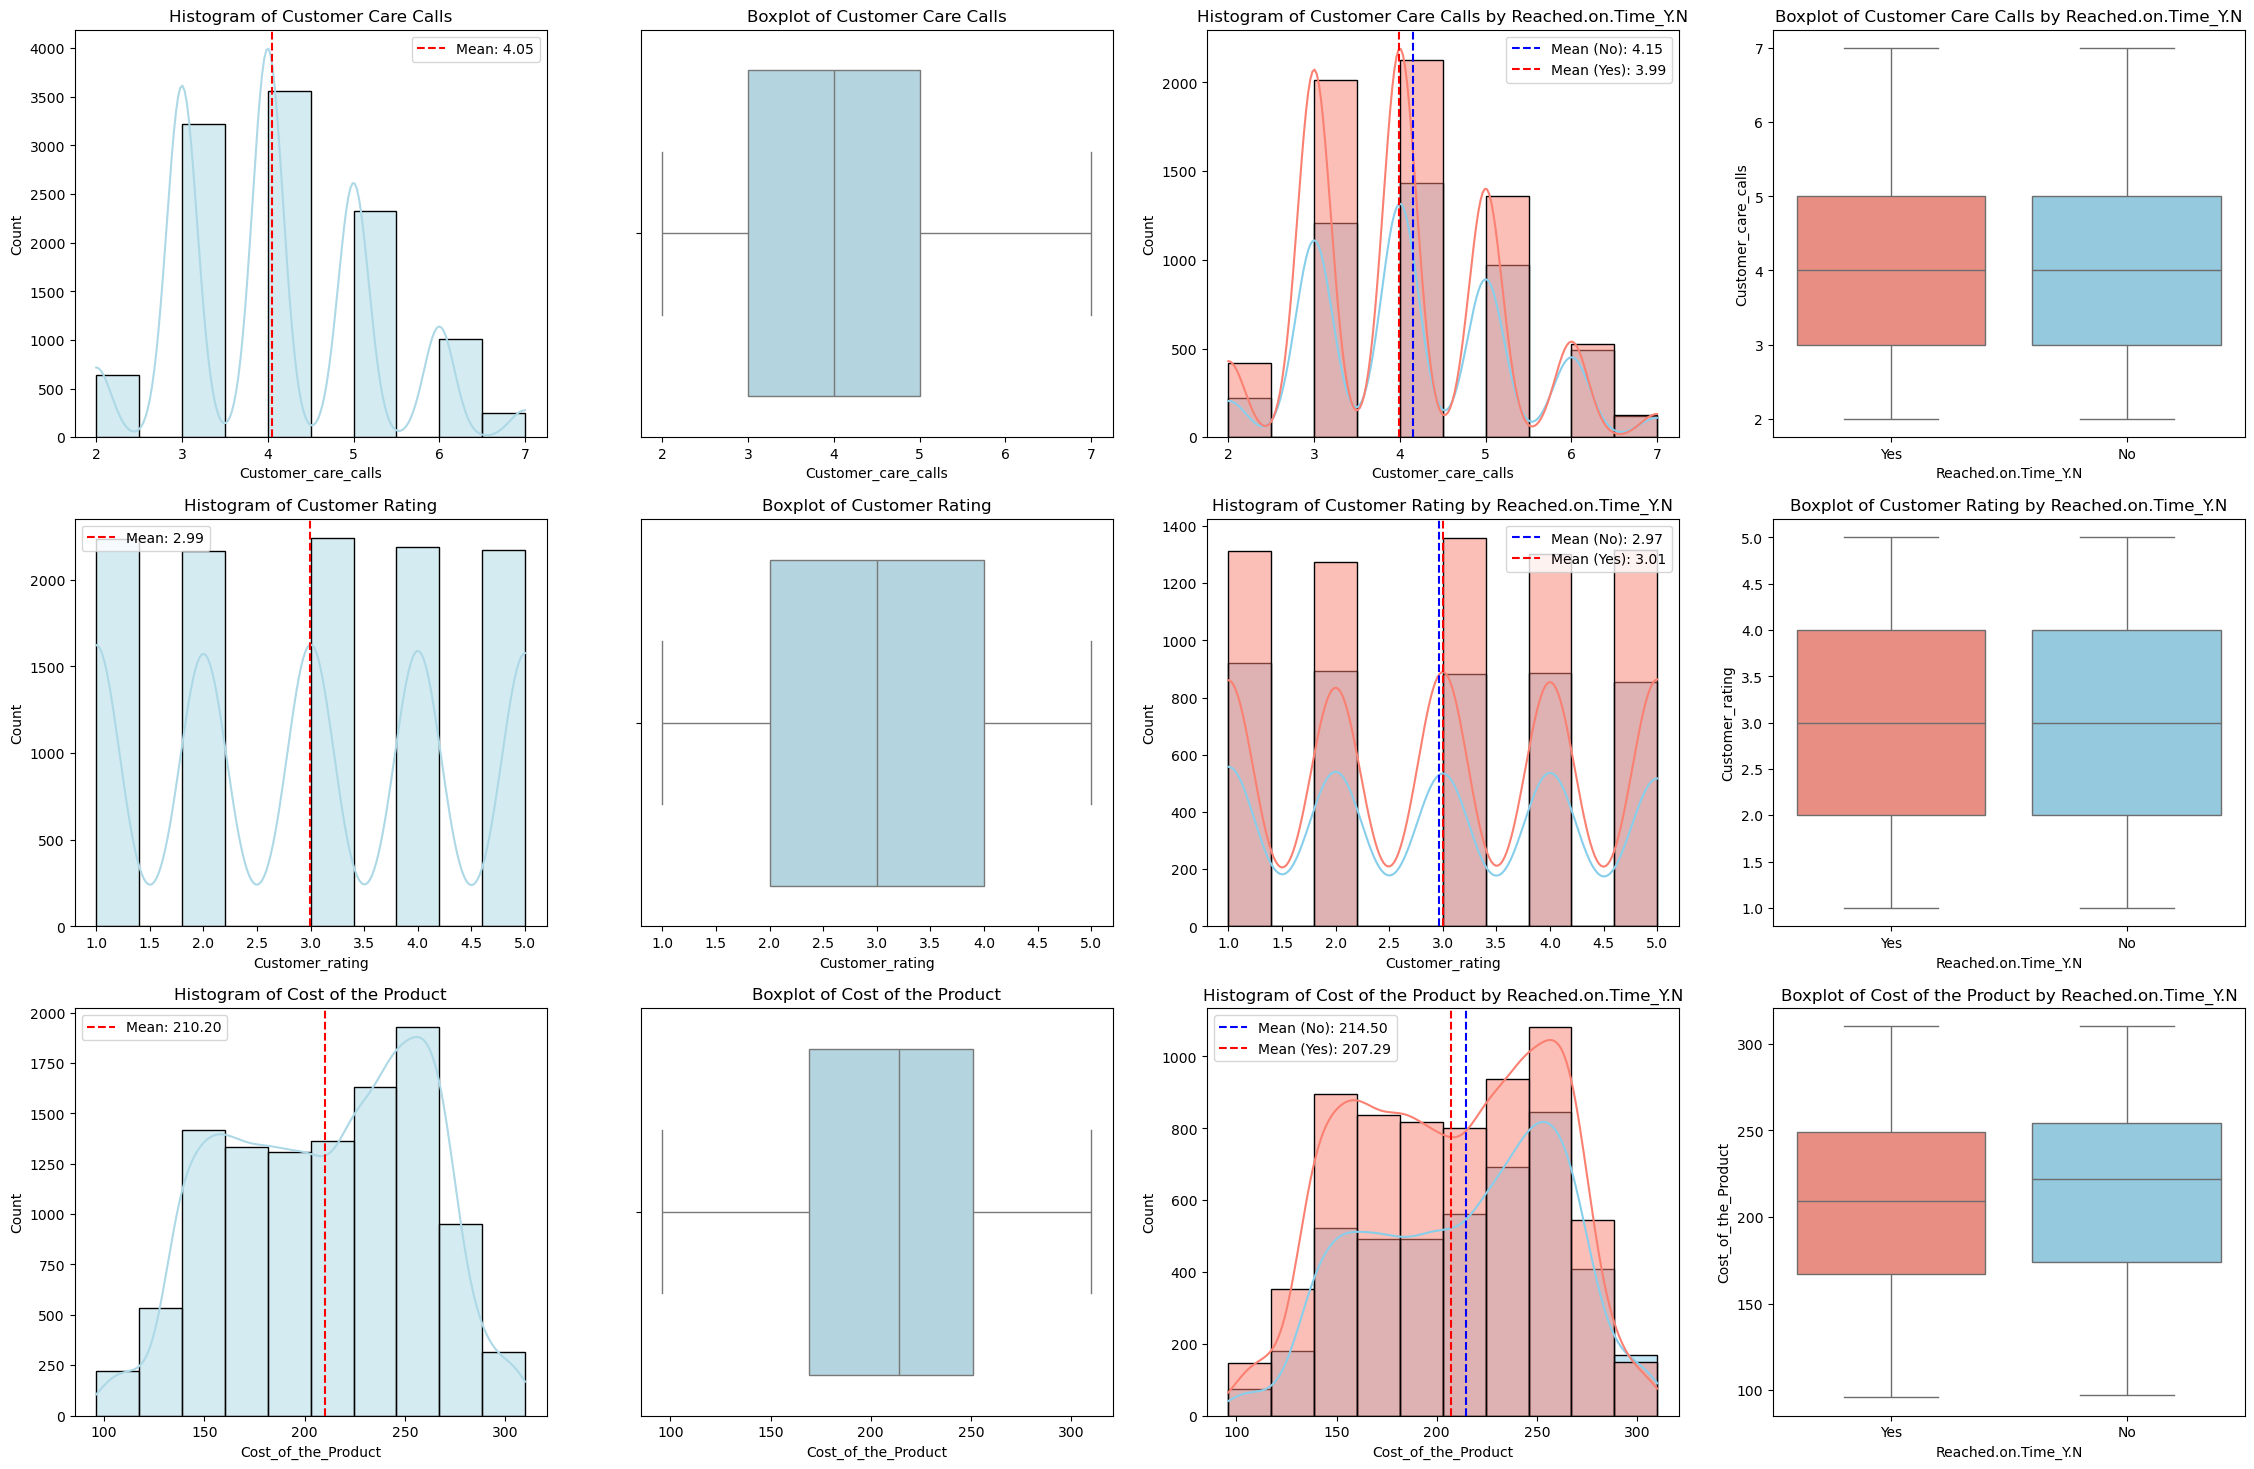

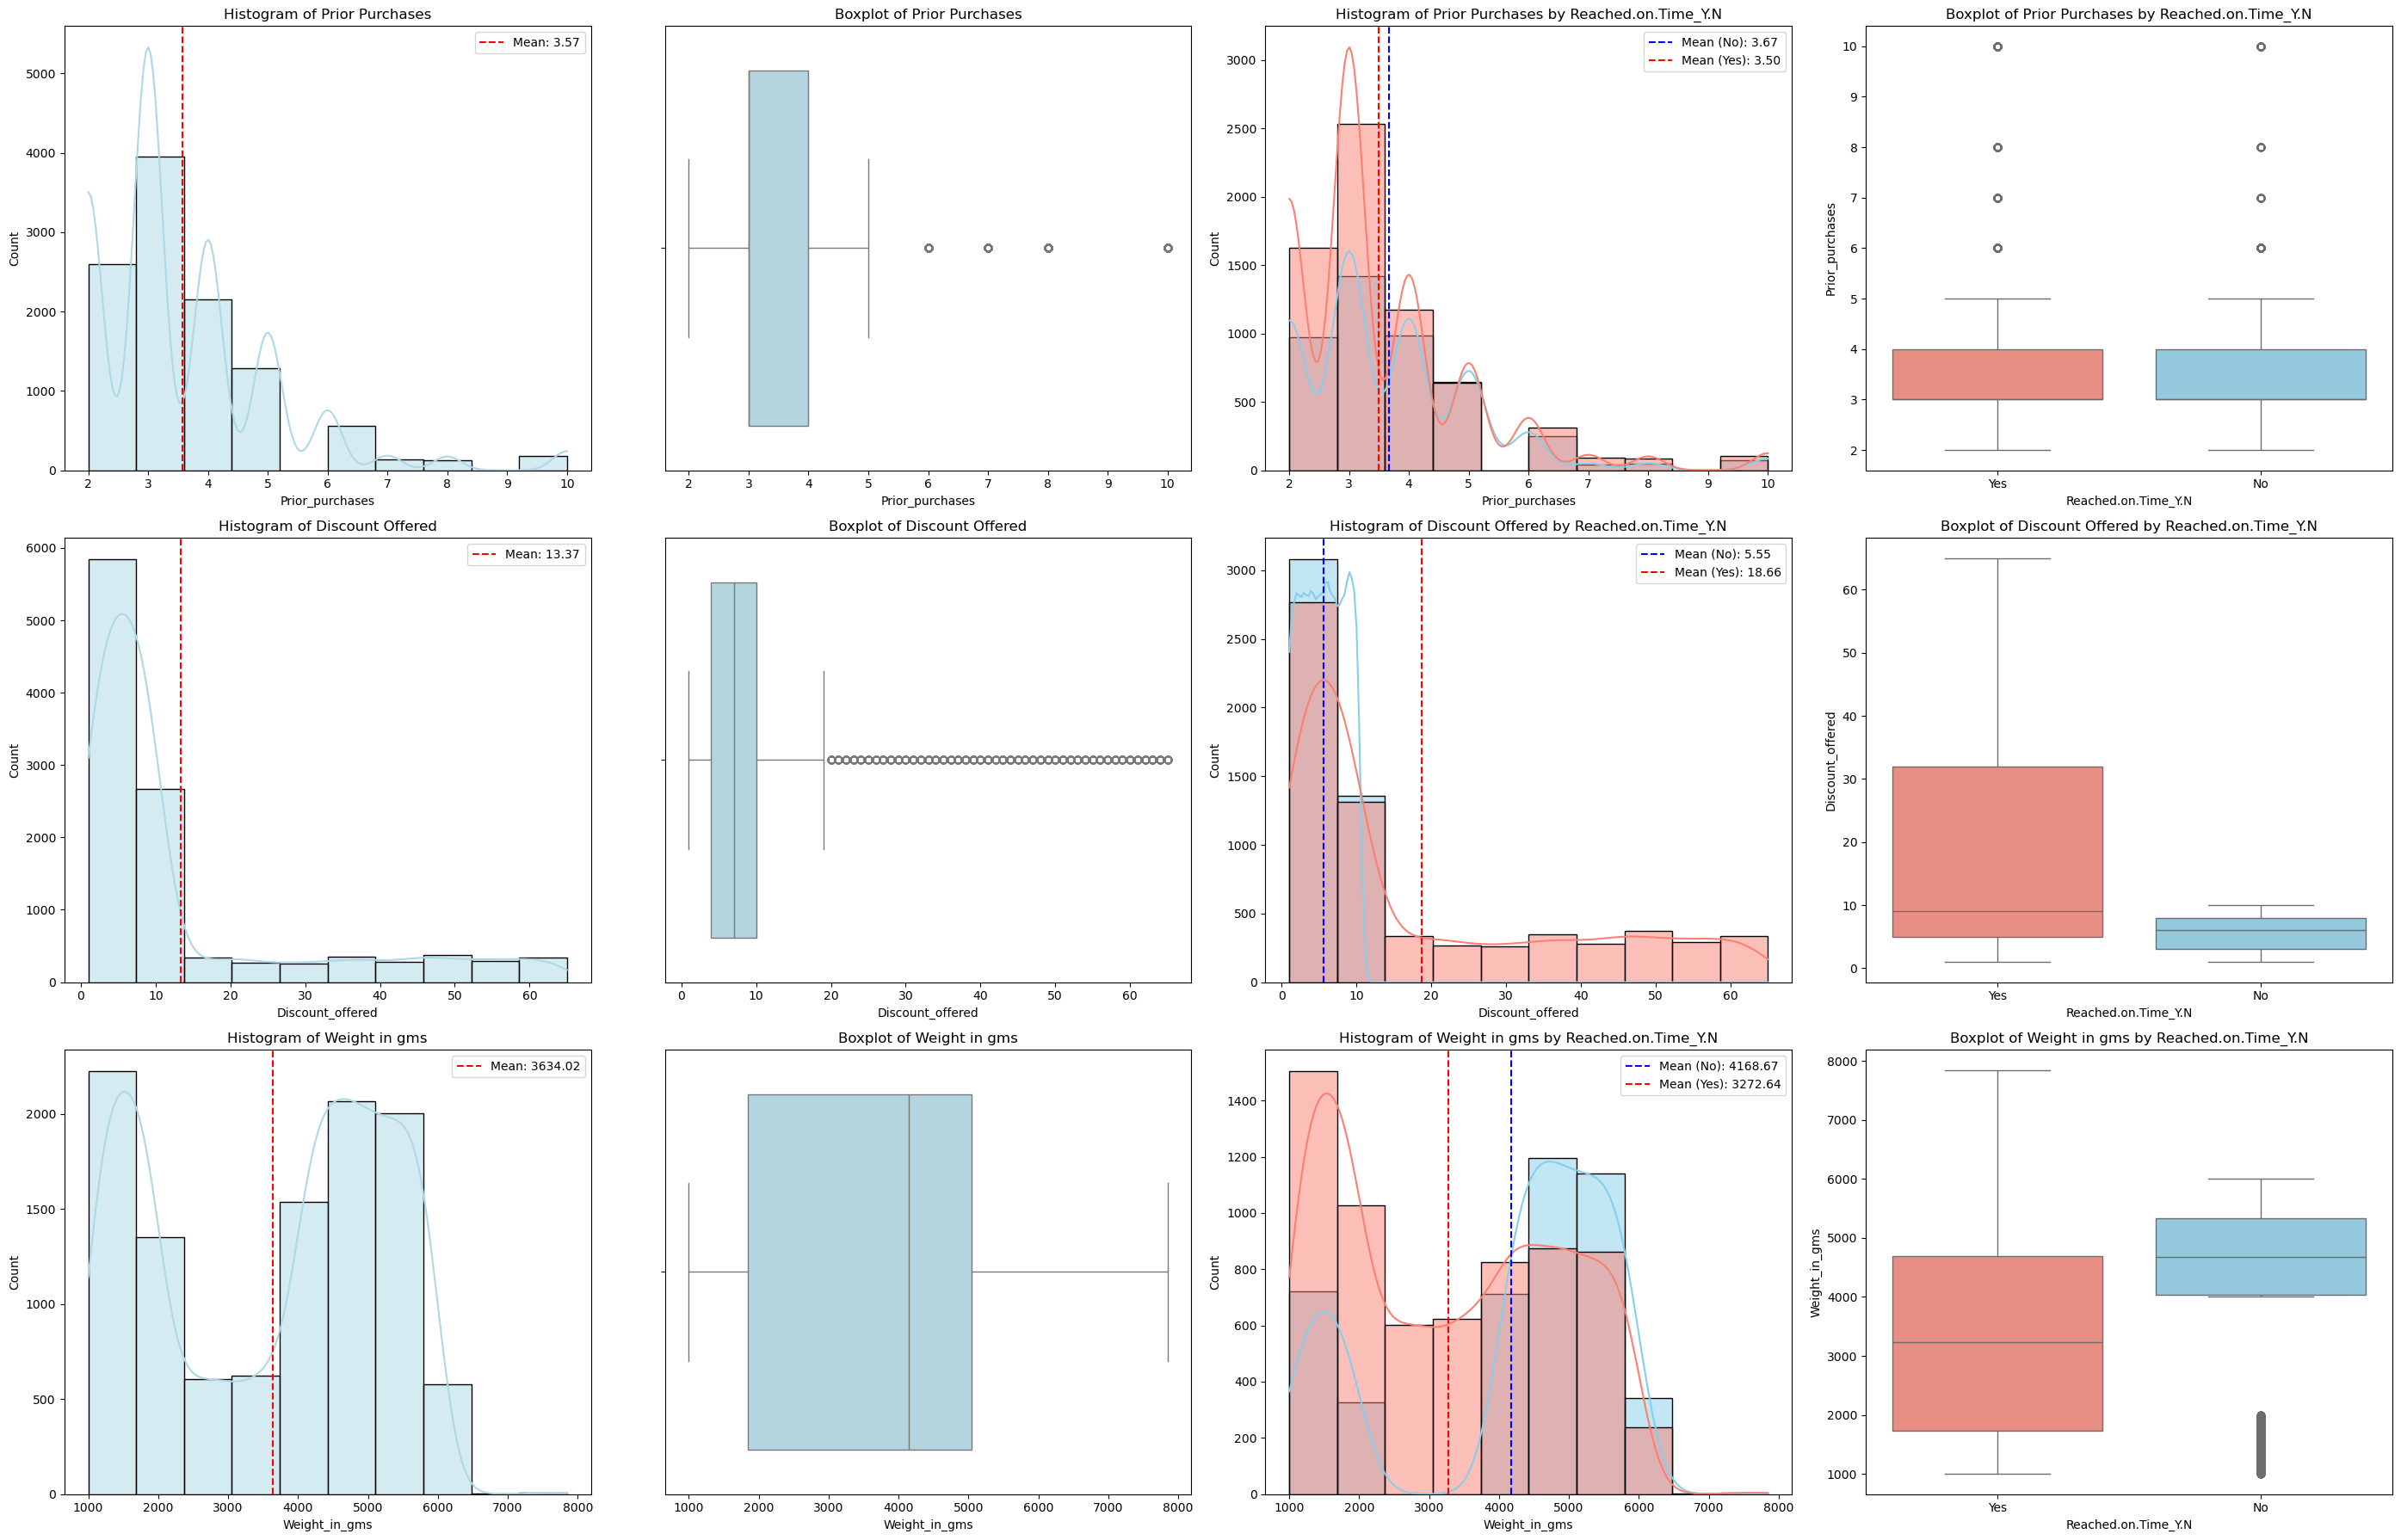

In [11]:
custom_palette = {"Yes": "salmon", "No": "skyblue"}

fig, axes = plt.subplots(3, 4, figsize=(28, 18))

sns.histplot(df["Customer_care_calls"], kde=True, ax=axes[0, 0], bins=10, color="lightblue")
axes[0, 0].axvline(df["Customer_care_calls"].mean(), color="red", linestyle="--", label=f"Mean: {df['Customer_care_calls'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].set_title("Histogram of Customer Care Calls")

sns.boxplot(x=df["Customer_care_calls"], ax=axes[0, 1], color="lightblue")
axes[0, 1].set_title("Boxplot of Customer Care Calls")

sns.histplot(
    data=df,
    x="Customer_care_calls",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[0, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[0, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Customer_care_calls"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Customer_care_calls'].mean():.2f}"
        )
axes[0, 2].legend()
axes[0, 2].set_title("Histogram of Customer Care Calls by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Customer_care_calls",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[0, 3],
    palette=custom_palette,
    legend=False
)
axes[0, 3].set_title("Boxplot of Customer Care Calls by Reached.on.Time_Y.N")

sns.histplot(df["Customer_rating"], kde=True, ax=axes[1, 0], bins=10, color="lightblue")
axes[1, 0].axvline(df["Customer_rating"].mean(), color="red", linestyle="--", label=f"Mean: {df['Customer_rating'].mean():.2f}")
axes[1, 0].legend()
axes[1, 0].set_title("Histogram of Customer Rating")

sns.boxplot(x=df["Customer_rating"], ax=axes[1, 1], color="lightblue")
axes[1, 1].set_title("Boxplot of Customer Rating")

sns.histplot(
    data=df,
    x="Customer_rating",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[1, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[1, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Customer_rating"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Customer_rating'].mean():.2f}"
        )
axes[1, 2].legend()
axes[1, 2].set_title("Histogram of Customer Rating by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Customer_rating",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[1, 3],
    palette=custom_palette,
    legend=False
)
axes[1, 3].set_title("Boxplot of Customer Rating by Reached.on.Time_Y.N")

sns.histplot(df["Cost_of_the_Product"], kde=True, ax=axes[2, 0], bins=10, color="lightblue")
axes[2, 0].axvline(df["Cost_of_the_Product"].mean(), color="red", linestyle="--", label=f"Mean: {df['Cost_of_the_Product'].mean():.2f}")
axes[2, 0].legend()
axes[2, 0].set_title("Histogram of Cost of the Product")

sns.boxplot(x=df["Cost_of_the_Product"], ax=axes[2, 1], color="lightblue")
axes[2, 1].set_title("Boxplot of Cost of the Product")

sns.histplot(
    data=df,
    x="Cost_of_the_Product",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[2, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[2, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Cost_of_the_Product"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Cost_of_the_Product'].mean():.2f}"
        )
axes[2, 2].legend()
axes[2, 2].set_title("Histogram of Cost of the Product by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Cost_of_the_Product",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[2, 3],
    palette=custom_palette,
    legend=False
)
axes[2, 3].set_title("Boxplot of Cost of the Product by Reached.on.Time_Y.N")

fig, axes = plt.subplots(3, 4, figsize=(28, 18))

sns.histplot(df["Prior_purchases"], kde=True, ax=axes[0, 0], bins=10, color="lightblue")
axes[0, 0].axvline(df["Prior_purchases"].mean(), color="red", linestyle="--", label=f"Mean: {df['Prior_purchases'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].set_title("Histogram of Prior Purchases")

sns.boxplot(x=df["Prior_purchases"], ax=axes[0, 1], color="lightblue")
axes[0, 1].set_title("Boxplot of Prior Purchases")

sns.histplot(
    data=df,
    x="Prior_purchases",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[0, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[0, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Prior_purchases"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Prior_purchases'].mean():.2f}"
        )
axes[0, 2].legend()
axes[0, 2].set_title("Histogram of Prior Purchases by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Prior_purchases",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[0, 3],
    palette=custom_palette,
    legend=False
)
axes[0, 3].set_title("Boxplot of Prior Purchases by Reached.on.Time_Y.N")

sns.histplot(df["Discount_offered"], kde=True, ax=axes[1, 0], bins=10, color="lightblue")
axes[1, 0].axvline(df["Discount_offered"].mean(), color="red", linestyle="--", label=f"Mean: {df['Discount_offered'].mean():.2f}")
axes[1, 0].legend()
axes[1, 0].set_title("Histogram of Discount Offered")

sns.boxplot(x=df["Discount_offered"], ax=axes[1, 1], color="lightblue")
axes[1, 1].set_title("Boxplot of Discount Offered")

sns.histplot(
    data=df,
    x="Discount_offered",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[1, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[1, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Discount_offered"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Discount_offered'].mean():.2f}"
        )
axes[1, 2].legend()
axes[1, 2].set_title("Histogram of Discount Offered by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Discount_offered",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[1, 3],
    palette=custom_palette,
    legend=False
)
axes[1, 3].set_title("Boxplot of Discount Offered by Reached.on.Time_Y.N")

sns.histplot(df["Weight_in_gms"], kde=True, ax=axes[2, 0], bins=10, color="lightblue")
axes[2, 0].axvline(df["Weight_in_gms"].mean(), color="red", linestyle="--", label=f"Mean: {df['Weight_in_gms'].mean():.2f}")
axes[2, 0].legend()
axes[2, 0].set_title("Histogram of Weight in gms")

sns.boxplot(x=df["Weight_in_gms"], ax=axes[2, 1], color="lightblue")
axes[2, 1].set_title("Boxplot of Weight in gms")

sns.histplot(
    data=df,
    x="Weight_in_gms",
    hue="Reached.on.Time_Y.N",
    kde=True,
    ax=axes[2, 2],
    bins=10,
    palette=custom_palette,
)
for grp, color in zip(["No", "Yes"], ["blue", "red"]):
    if grp in df["Reached.on.Time_Y.N"].unique():
        axes[2, 2].axvline(
            df[df["Reached.on.Time_Y.N"] == grp]["Weight_in_gms"].mean(),
            color=color,
            linestyle="--",
            label=f"Mean ({grp}): {df[df['Reached.on.Time_Y.N'] == grp]['Weight_in_gms'].mean():.2f}"
        )
axes[2, 2].legend()
axes[2, 2].set_title("Histogram of Weight in gms by Reached.on.Time_Y.N")

sns.boxplot(
    x="Reached.on.Time_Y.N",
    y="Weight_in_gms",
    hue="Reached.on.Time_Y.N",
    data=df,
    ax=axes[2, 3],
    palette=custom_palette,
    legend=False
)
axes[2, 3].set_title("Boxplot of Weight in gms by Reached.on.Time_Y.N")

plt.tight_layout()
plt.show()

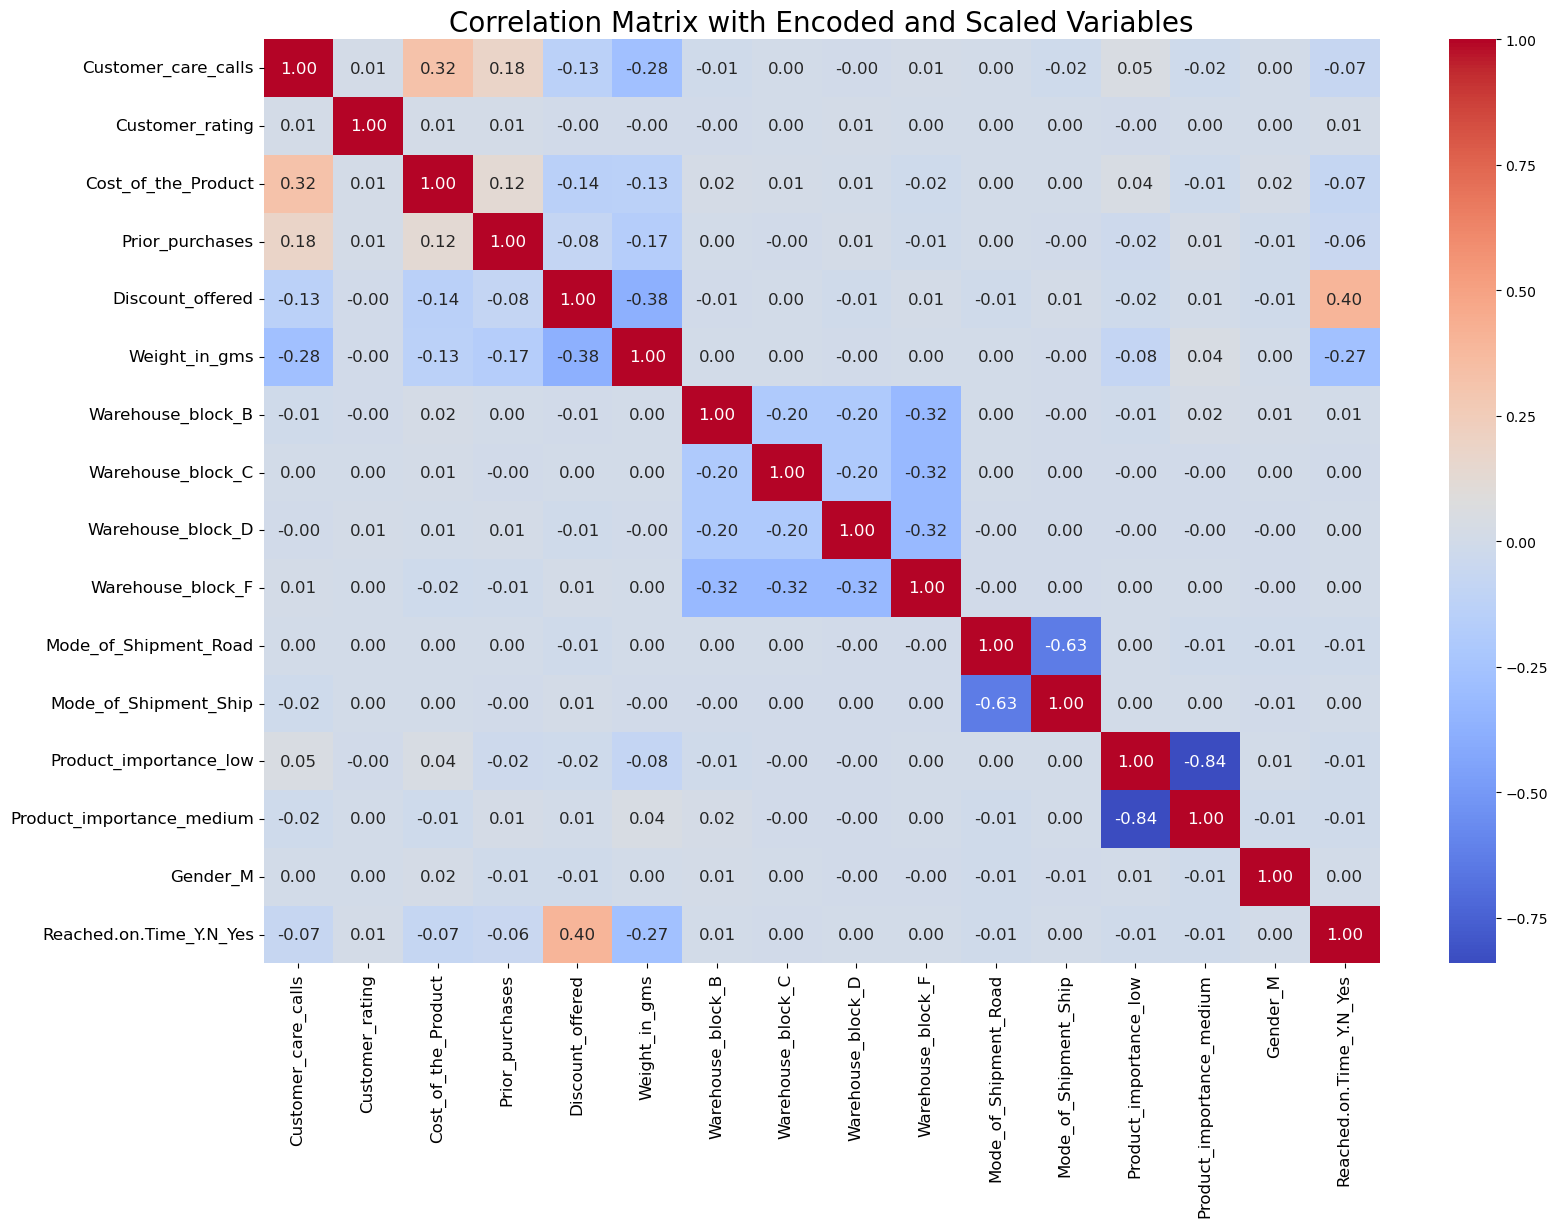

In [12]:
numeric_features = [
    "Customer_care_calls",
    "Customer_rating",
    "Cost_of_the_Product",
    "Prior_purchases",
    "Discount_offered",
    "Weight_in_gms"
]

categorical_features = [
    "Warehouse_block",
    "Mode_of_Shipment",
    "Product_importance",
    "Gender",
    "Reached.on.Time_Y.N"
]

scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numeric_features])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numeric_features)

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_features])
encoded_categorical_df = pd.DataFrame(
    encoded_categorical, columns=encoder.get_feature_names_out(categorical_features)
)

processed_df = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)

correlation_matrix = processed_df.corr()

plt.figure(figsize=(18, 12))
num_features = len(correlation_matrix)
font_size = max(5, 200 // num_features)

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    annot_kws={"size": font_size},
)

plt.title("Correlation Matrix with Encoded and Scaled Variables", fontsize=20)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()

In [13]:
df["Reached.on.Time_Y.N"] = np.where(df["Reached.on.Time_Y.N"] == "Yes", 1, 0).astype(int)

In [14]:
X = df.drop(columns=["Reached.on.Time_Y.N"])
y = df["Reached.on.Time_Y.N"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.6, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [15]:
numerical_features = [
    "Customer_care_calls",
    "Customer_rating",
    "Cost_of_the_Product",
    "Prior_purchases",
    "Discount_offered",
    "Weight_in_gms"
]

categorical_features = [
    "Warehouse_block",
    "Mode_of_Shipment",
    "Product_importance",
    "Gender"
]

numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

numerical_columns = numerical_features
categorical_columns = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_features)
all_columns = list(numerical_columns) + list(categorical_columns)

X_train_processed = pd.DataFrame(X_train_transformed, columns=all_columns, index=X_train.index)
X_val_processed = pd.DataFrame(X_val_transformed, columns=all_columns, index=X_val.index)
X_test_processed = pd.DataFrame(X_test_transformed, columns=all_columns, index=X_test.index)

X_train = X_train_processed
X_val = X_val_processed
X_test = X_test_processed

print("Shape of processed train set:", X_train.shape)
print("Shape of processed val set:", X_val.shape)
print("Shape of processed test set:", X_test.shape)

Shape of processed train set: (6599, 19)
Shape of processed val set: (2200, 19)
Shape of processed test set: (2200, 19)


In [16]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
}

param_grids = {
    "Logistic Regression": {
        "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__solver": ["liblinear", "lbfgs", "saga"],
        "classifier__penalty": ["l2"],
        "classifier__max_iter": [500, 1000, 2000, 3000],
    },
    "XGBoost": {
        "classifier__n_estimators": [50, 100, 150, 200],
        "classifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "classifier__max_depth": [3, 5, 7, 10],
        "classifier__min_child_weight": [1, 2, 5, 10],
        "classifier__subsample": [0.7, 0.8, 0.9, 1.0],
        "classifier__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    },
    "Support Vector Classifier": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"],
    },
    "K-Nearest Neighbors": {
        "classifier__n_neighbors": [3, 5, 7, 9, 11, 15],
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["euclidean", "manhattan", "minkowski"],
        "classifier__p": [1, 2],
        "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "CatBoost": {
        "classifier__iterations": [100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.3],
        "classifier__depth": [4, 6, 8],
        "classifier__l2_leaf_reg": [1, 3, 5],
    },
}

In [17]:
best_models = {}

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

for model_name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("classifier", model)
        ]
    )

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[model_name],
        cv=stratified_cv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=2,
    )

    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=


Logistic Regression - Accuracy: 0.61, Recall: 0.82, ROC-AUC: 0.72
              precision    recall  f1-score   support

           0       0.53      0.31      0.39       888
           1       0.64      0.82      0.71      1312

    accuracy                           0.61      2200
   macro avg       0.58      0.56      0.55      2200
weighted avg       0.59      0.61      0.58      2200


XGBoost - Accuracy: 0.67, Recall: 0.56, ROC-AUC: 0.74
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       888
           1       0.83      0.56      0.67      1312

    accuracy                           0.67      2200
   macro avg       0.70      0.70      0.67      2200
weighted avg       0.72      0.67      0.67      2200


Support Vector Classifier - Accuracy: 0.65, Recall: 0.53, ROC-AUC: 0.73
              precision    recall  f1-score   support

           0       0.55      0.84      0.66       888
           1       0.83      0.53      0.6

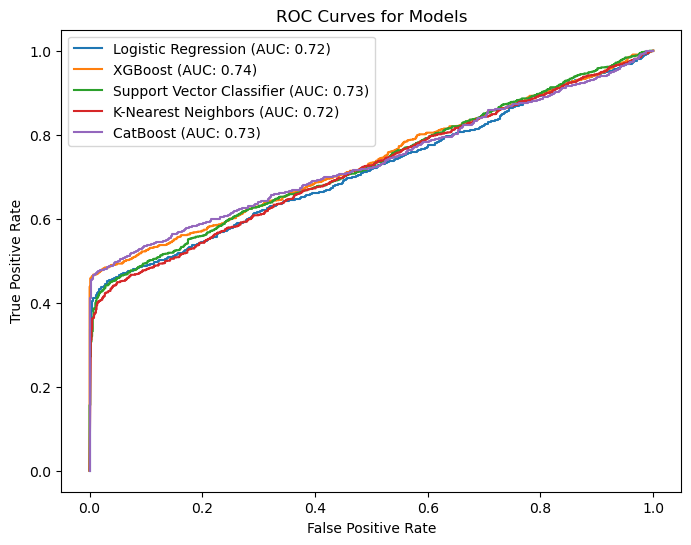

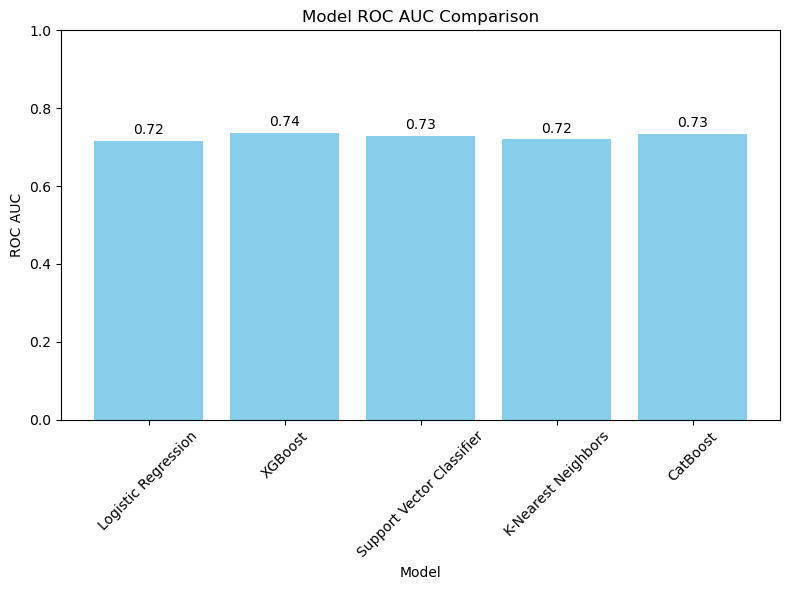

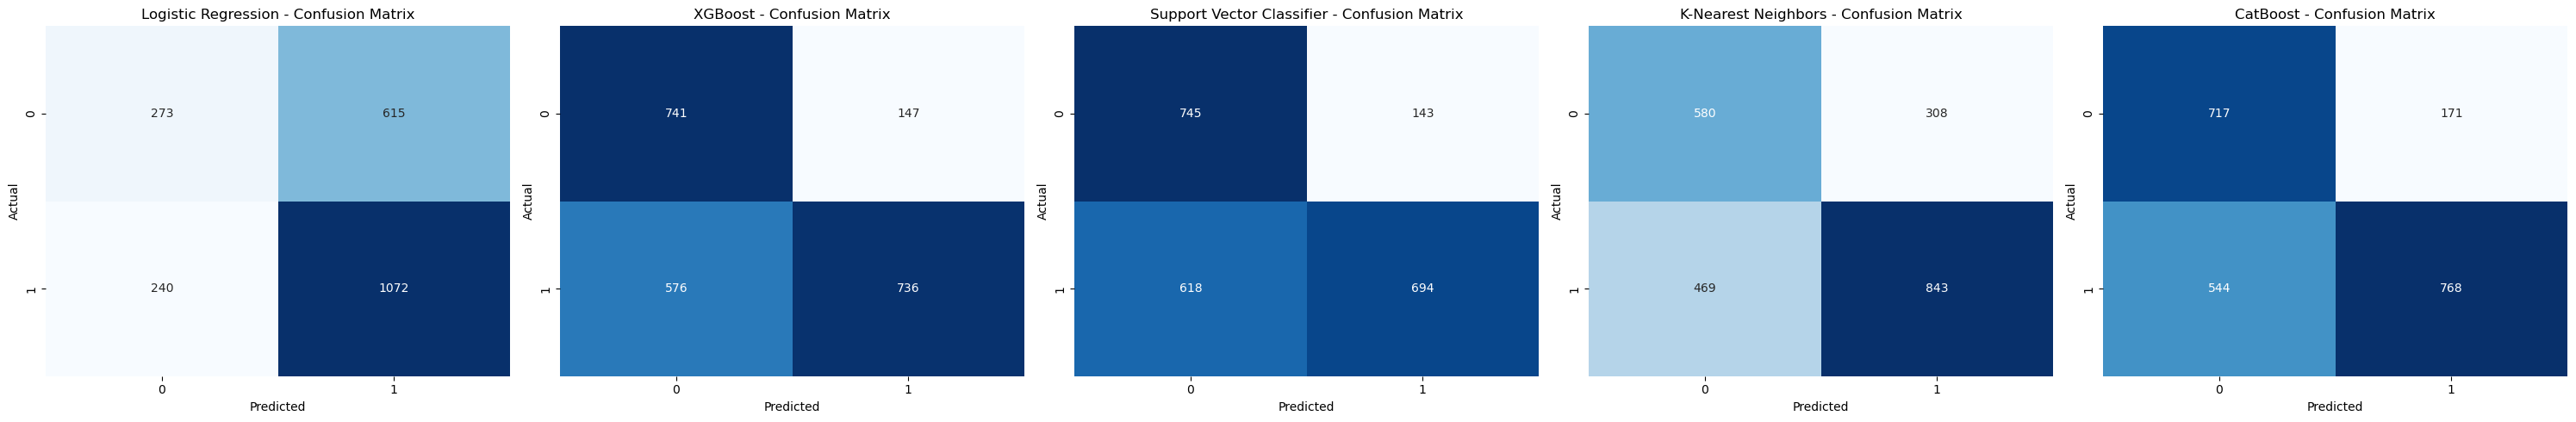

In [18]:
results = {"Model": [], "Accuracy": [], "Recall": [], "ROC_AUC": []}

confusion_matrices = []
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="binary")
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)

    confusion_matrices.append((model_name, cm))
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy)
    results["Recall"].append(recall)
    results["ROC_AUC"].append(roc_auc)

    print(
        f"\n{model_name} - Accuracy: {accuracy:.2f}, Recall: {recall:.2f}, ROC-AUC: {roc_auc:.2f}"
        if roc_auc
        else f"{model_name} - Accuracy: {accuracy:.2f}, Recall: {recall:.2f}"
    )
    print(classification_report(y_test, y_pred, zero_division=0))

df_results = pd.DataFrame(results)
print("\nAggregated Results:")
print(df_results)

plt.figure(figsize=(8, 6))
for model_name, best_model in best_models.items():
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
bars = plt.bar(df_results["Model"], df_results["ROC_AUC"], color="skyblue")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        f"{yval:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("Model")
plt.ylabel("ROC AUC")
plt.title("Model ROC AUC Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

num_models = len(confusion_matrices)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

for ax, (model_name, cm) in zip(axes, confusion_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

Final Evaluation of XGBoost on Validation Set:
Accuracy: 0.67
Recall: 0.56
ROC-AUC Score: 0.74

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67       887
           1       0.84      0.56      0.67      1313

    accuracy                           0.67      2200
   macro avg       0.70      0.70      0.67      2200
weighted avg       0.73      0.67      0.67      2200



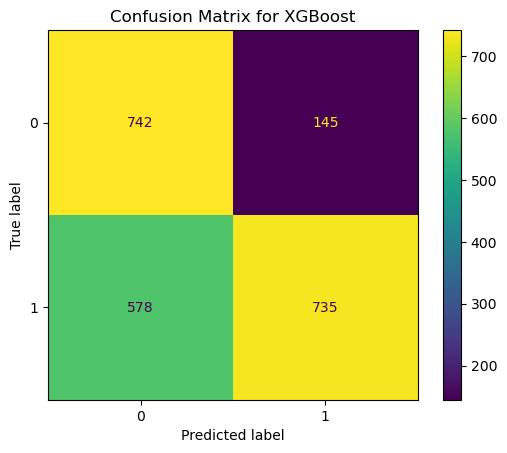

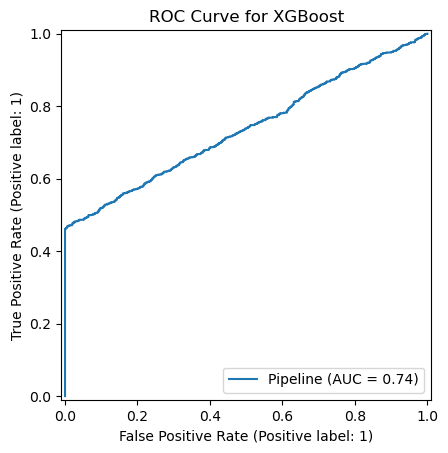

In [19]:
model_of_choice = best_models["XGBoost"]

y_pred = model_of_choice.predict(X_val)
y_pred_prob = model_of_choice.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred, average="binary")
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(f"Final Evaluation of XGBoost on Validation Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}\n")
print("🧾 Classification Report:")
print(classification_report(y_val, y_pred, zero_division=0))

ConfusionMatrixDisplay.from_estimator(model_of_choice, X_val, y_val)
plt.title("Confusion Matrix for XGBoost")
plt.show()

RocCurveDisplay.from_estimator(model_of_choice, X_val, y_val)
plt.title("ROC Curve for XGBoost")
plt.show()